In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import tat_neuro_functions as tnf
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [57]:
df = pd.read_csv('/Users/Greg/Projects/HIV_Neuro_NGS/DataModeling/dataframes/clin_clean_df.csv')
print df.shape
df.head()

(117, 14)


,Age,log10_VL,log10_pVL,CD4,nCD4,CD8,nCD8,TMHDS,Years_seropositive,Exposure_MSM,Exposure_IDU,Exposure_heterosexual,Gender_Male,GDS
0,0.977462,-0.450448,-0.780043,0.286021,0.598424,0.478651,1.112201,-1.571159,0.275913,-0.547723,2.607681,-1.098885,0.776363,1
1,0.977462,-0.450448,-1.021905,1.232499,0.834713,-0.617639,-0.502773,-1.571159,0.592401,1.825742,-0.383482,-1.098885,0.776363,1
2,1.496115,-0.203587,0.316819,0.500897,0.613192,1.574941,0.634923,-0.459311,2.016596,1.825742,-0.383482,-1.098885,0.776363,1
3,2.144432,-0.450448,0.421599,0.219511,1.351597,0.073398,0.829164,-0.644619,-0.198819,-0.547723,-0.383482,-1.098885,0.776363,0
4,0.329145,-0.450448,0.648911,-0.317679,-0.267972,1.593681,1.744872,-0.088694,1.383620,1.825742,2.607681,-1.098885,0.776363,1


In [58]:
#f1 = ['log10_pVL','nCD4'] # window of neurological vulnerability
f1 = ['Age','Years_seropositive','TMHDS','CD4']
f2 = ['log10_VL','CD4'] # current status by traditional metrics
f3 = ['TMHDS'] # screen of neuro-impairment
#f4 = ['log10_pVL','nCD4','log10_VL','CD4','TMHDS'] # all 5 traditional features
feats = [f1, f2, f3]

In [59]:
target = 'GDS'
threshold = 0.5
folds = 5
#features = f4

# record data for different feature sets
D = []
for features in feats:
    print features

    # record data for different regularization ############################################
    AUC1, AUC2 = [], []
    PREC1, PREC2 = [], []
    REC1, REC2 = [], []
    F1, F2 = [], []
    TPR1, TPR2 = [], []
    FPR1, FPR2 = [], []
    COEF1, COEF2 = [], []

    # iterate through regularization parameters
    reg_coeffs = list(10.0**np.arange(3,-4,-1))
    for rc in reg_coeffs:
        print rc

        # lasso model
        lasso_model = LogisticRegression(penalty='l1',solver='liblinear',fit_intercept=True,
                                         C=rc, class_weight='balanced', n_jobs=-1)
        # ridge model
        ridge_model = LogisticRegression(penalty='l2',solver='liblinear',fit_intercept=True,
                                         C=rc, class_weight='balanced', n_jobs=-1)

        # shuffle and analyze the dataframe 1000 times ####################################
        auc1, auc2 = [], []
        prec1, prec2 = [], []
        rec1, rec2 = [], []
        f1, f2 = [], []
        tpr1, tpr2 = [], []
        fpr1, fpr2 = [], []
        coef1, coef2 = [], []

        for _ in range(100):

            # shuffle the dataframe
            df_shuffled = tnf.shuffle_dataframe(df)

            # select 100 samples from the shuffled dataframe
            # prepare the dataframe for sklearn
            X_df, y = tnf.run_preparation_pipeline2(df_shuffled[:100], features, target, threshold)

            # run k-fold cross validation
            lasso_metrics = tnf.get_CV_metrics(lasso_model, X_df[features], y, folds)
            ridge_metrics = tnf.get_CV_metrics(ridge_model, X_df[features], y, folds)

            # append data for each random sample 
            # lasso metrics
            auc1.append(np.mean(lasso_metrics['AUC']))
            prec1.append(np.mean(lasso_metrics['Precision']))
            rec1.append(np.mean(lasso_metrics['Recall']))
            f1.append(np.mean(lasso_metrics['F1']))
            tpr1.append(lasso_metrics['meanTPR'])
            fpr1.append(lasso_metrics['meanFPR'])
            coef1.append(lasso_metrics['Coef'])
            # ridge metrics
            auc2.append(np.mean(ridge_metrics['AUC']))
            prec2.append(np.mean(ridge_metrics['Precision']))
            rec2.append(np.mean(ridge_metrics['Recall']))
            f2.append(np.mean(ridge_metrics['F1']))
            tpr2.append(ridge_metrics['meanTPR'])
            fpr2.append(ridge_metrics['meanFPR'])
            coef2.append(ridge_metrics['Coef'])

        #append results for each model
        AUC1.append(auc1)
        PREC1.append(prec1)
        REC1.append(rec1)
        F1.append(f1)
        TPR1.append(tpr1) 
        FPR1.append(fpr1) 
        COEF1.append(coef1) 

        AUC2.append(auc2)
        PREC2.append(prec2)
        REC2.append(rec2)
        F2.append(f2)
        TPR2.append(tpr2) 
        FPR2.append(fpr2) 
        COEF2.append(coef2)
    
    # append to overall data
    D.append([features, AUC1, AUC2])

['Age', 'Years_seropositive', 'TMHDS', 'CD4']
1000.0
100.0
10.0
1.0


KeyboardInterrupt: 

['Age', 'Years_seropositive', 'TMHDS', 'CD4']
['log10_VL', 'CD4']
['TMHDS']


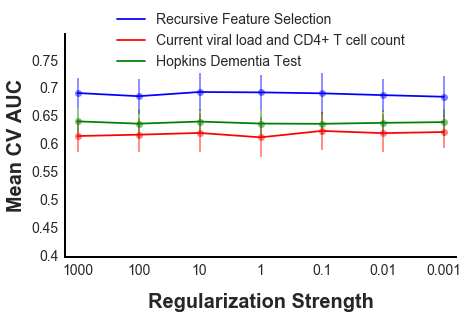

In [5]:
fig, ax = plt.subplots(1,1,figsize=(7,4))

for i in range(len(D)):
    print D[i][0]
    A2 = D[i][2]
    a2_df = pd.DataFrame(A2).T
    mean_2 = list(a2_df.mean(axis=0))
    std_2 = list(a2_df.std(axis=0))
    
    x = np.arange(0,7,1)
    y = mean_2
    ye = std_2
    
    color_options = ['blue','red','green']
    labels = ['Recursive Feature Selection',
              'Current viral load and CD4+ T cell count',
              'Hopkins Dementia Test']
    
    ax.errorbar(x, y, yerr=ye, fmt='o', alpha=0.5, color=color_options[i])
    ax.plot(mean_2, color=color_options[i], label=labels[i])

legend = ax.legend(loc='upper center', shadow=True, fontsize=14,
                   bbox_to_anchor=(0.5, 1.15), fancybox=True)

# formatting colors and axes
ax.set_axis_bgcolor('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)

N = 7
ind = np.arange(N)

ax.set_ylabel('Mean CV AUC', weight='bold', fontsize=20)
ax.set_xlim([-0.2,6.2])
ax.set_xticks(ind)
labels = ['1000', '100', '10', '1', '0.1', '0.01', '0.001']
ax.set_xticklabels(labels, fontsize=14)
ax.set_ylim([0.4,0.8])
ax.set_yticklabels(np.arange(0.4,0.8,0.05),fontsize=14)
ax.set_xlabel('Regularization Strength', labelpad=15, fontsize=20, weight='bold')

plt.show()

fig.tight_layout()
savepath = '/Users/Greg/Projects/HIV_Neuro_NGS/Figures/clin_auc_benchmarks.png'
fig.savefig(savepath,dpi=300,bbox_inches='tight')

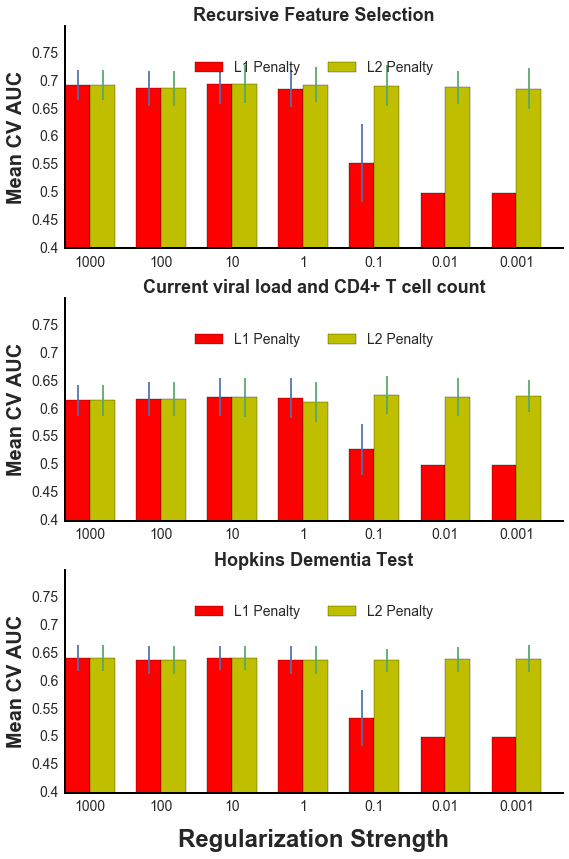

In [6]:
N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

# intialize subplots
fig, ax = plt.subplots(3,1,figsize=(8,12))

for i in range(len(D)):
    #print i, D[i][0]
    A1 = D[i][1]
    A2 = D[i][2]
    a1_df = pd.DataFrame(A1).T
    a2_df = pd.DataFrame(A2).T
    
    mean_1 = list(a1_df.mean(axis=0))
    mean_2 = list(a2_df.mean(axis=0))
    std_1 = list(a1_df.std(axis=0))
    std_2 = list(a2_df.std(axis=0))
    
    # plot histograms
    rects1 = ax[i].bar(ind, mean_1, width, color='r', yerr=std_1)
    rects2 = ax[i].bar(ind + width, mean_2, width, color='y', yerr=std_2)

    # add some text for labels, title and axes ticks
    #ax[i].set_title(feats[i], weight='bold', fontsize=18)
    ax[i].set_ylabel('Mean CV AUC', weight='bold', fontsize=20)
    
    ax[i].set_xticks(ind + width)
    labels = ['1000', '100', '10', '1', '0.1', '0.01', '0.001']
    ax[i].set_xticklabels(labels, fontsize=14)
    ax[i].set_ylim([0.4,0.8])
    ax[i].set_yticklabels(np.arange(0.4,0.8,0.05),fontsize=14)

    # formatting colors and axes
    ax[i].set_axis_bgcolor('white')
    ax[i].spines['left'].set_visible(True)
    ax[i].spines['left'].set_color('black')
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['bottom'].set_color('black')
    ax[i].spines['bottom'].set_linewidth(2)
    
    ax[i].legend((rects1[0], rects2[0]), ('L1 Penalty', 'L2 Penalty'),fontsize=14,
              loc='upper center', bbox_to_anchor=(0.5, 0.9),ncol=2, fancybox=True)

ax[0].set_title('Recursive Feature Selection', weight='bold', fontsize=18)
ax[1].set_title('Current viral load and CD4+ T cell count', weight='bold', fontsize=18)
ax[2].set_title('Hopkins Dementia Test', weight='bold', fontsize=18)

ax[2].set_xlabel('Regularization Strength', labelpad=15, fontsize=24, weight='bold')
    
fig.tight_layout()
#plt.show()

#fig.tight_layout()
#savepath = '/Users/Greg/Projects/HIV_Neuro_NGS/Figures/clin_auc_barplots_regularization.png'
#fig.savefig(savepath,dpi=300,bbox_inches='tight')

# ROC Plots

In [60]:
target = 'GDS'
threshold = 0.5
folds = 5
#features = f4

# record data for different feature sets
AUC1, AUC2 = [], []
PREC1, PREC2 = [], []
REC1, REC2 = [], []
F1, F2 = [], []
TPR1, TPR2 = [], []
FPR1, FPR2 = [], []
COEF1, COEF2 = [], []

for features in feats:
    print features

    # ridge model
    ridge_model = LogisticRegression(penalty='l2',solver='liblinear',fit_intercept=True,
                                     C=1, class_weight='balanced', n_jobs=-1)

    # shuffle and analyze the dataframe 100 times ####################################
    auc1, auc2 = [], []
    prec1, prec2 = [], []
    rec1, rec2 = [], []
    f1, f2 = [], []
    tpr1, tpr2 = [], []
    fpr1, fpr2 = [], []
    coef1, coef2 = [], []

    for _ in range(100):

        # shuffle the dataframe
        df_shuffled = tnf.shuffle_dataframe(df)

        # select 100 samples from the shuffled dataframe
        # prepare the dataframe for sklearn
        X_df, y = tnf.run_preparation_pipeline2(df_shuffled[:100], features, target, threshold)

        # run k-fold cross validation
        ridge_metrics = tnf.get_CV_metrics(ridge_model, X_df[features], y, folds)

        # append data for each random sample 
        # ridge metrics
        auc2.append(np.mean(ridge_metrics['AUC']))
        prec2.append(np.mean(ridge_metrics['Precision']))
        rec2.append(np.mean(ridge_metrics['Recall']))
        f2.append(np.mean(ridge_metrics['F1']))
        tpr2.append(ridge_metrics['meanTPR'])
        fpr2.append(ridge_metrics['meanFPR'])
        coef2.append(ridge_metrics['Coef'])

    #append results for each model
    AUC2.append(auc2)
    PREC2.append(prec2)
    REC2.append(rec2)
    F2.append(f2)
    TPR2.append(tpr2) 
    FPR2.append(fpr2) 
    COEF2.append(coef2)

['Age', 'Years_seropositive', 'TMHDS', 'CD4']
['log10_VL', 'CD4']
['TMHDS']


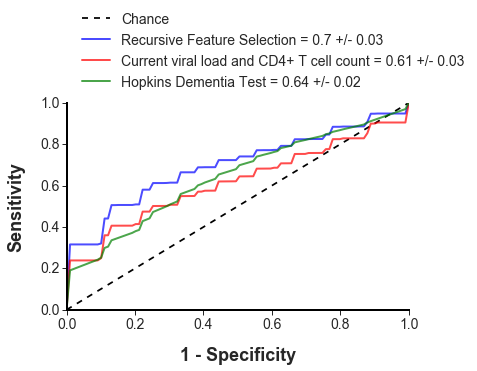

In [72]:
# iterate through the combinations of features

labels = ['Recursive Feature Selection',
              'Current viral load and CD4+ T cell count',
              'Hopkins Dementia Test']

fig,ax=plt.subplots(figsize=(6,4))

# formatting
ax.tick_params(axis='x', labelsize=14, length=5)
ax.tick_params(axis='y', labelsize=14, length=5)
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.set_xlabel('1 - Specificity', size=18, labelpad=15, weight='bold')
ax.set_ylabel('Sensitivity', size=18, labelpad=15, weight='bold')
ax.set_axis_bgcolor('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.ticklabel_format(size=20)
ax.plot([0, 1], [0, 1], ls='--', color='black', label='Chance')
clrs = ['blue','red','green','purple','orange','deeppink','aqua','gold','lime','sienna']

for j in range(len(feats)):
    # returns a list of arrays
    f = FPR2[j]
    t = TPR2[j]
    a = str(round(np.mean(AUC2[j]),2))
    b = str(round(np.std(AUC2[j]),2))
    
    # initialize a mean TRP and FPR
    X = np.zeros(len(f[0]))
    Y = np.zeros(len(t[0]))
    # iterate through each randomization
    for i in range(len(t)):
        X = X + f[i]
        Y = Y + t[i]
    X = X/len(t)
    Y = Y/len(t)
    ax.plot(X, Y, color=clrs[j], ls='-', label=labels[j]+' = '+a+' +/- '+b, linewidth=2, alpha=0.7)

fig.tight_layout()
plt.legend(bbox_to_anchor=[1.2, 1.5],ncol=1,fontsize=14)

savepath = '/Users/Greg/Projects/HIV_Neuro_NGS/Figures/clin_roc_plots.png'
fig.savefig(savepath,dpi=300, bbox_inches='tight')

# Plot Coefficients

In [27]:
coeff_dict_list = []

i=0
for feature_group in COEF2:
    #print len(feature_group)
    cv_mean_list = []
    for cv_group in feature_group:
        cv_mean = np.mean(cv_group,0)
        #print len(cv_group), cv_mean
        cv_mean_list.append(cv_mean)
    #print len(cv_mean_list), len(cv_mean_list[0][0])
    F = feats[i]
    S = np.mean(cv_mean_list,0)[0]
    Z = zip(F,S)
    coeff_dict_list.append(dict(Z))
    i+=1

X = []
VARS = ['TMHDS','Age','CD4','log10_VL','Years_seropositive']
for A in coeff_dict_list:
    x = []
    for V in VARS:
        if V in A.keys():
            x.append(A[V])
        else:
            x.append(np.nan)
    X.append(x)

coeff_df = pd.DataFrame(X)
coeff_df.columns = VARS
coeff_df.T

,0,1,2
TMHDS,-0.575003,NaN,-0.52985
Age,-0.446359,NaN,NaN
CD4,0.518317,0.579551,NaN
log10_VL,NaN,0.014780,NaN
Years_seropositive,0.360036,NaN,NaN


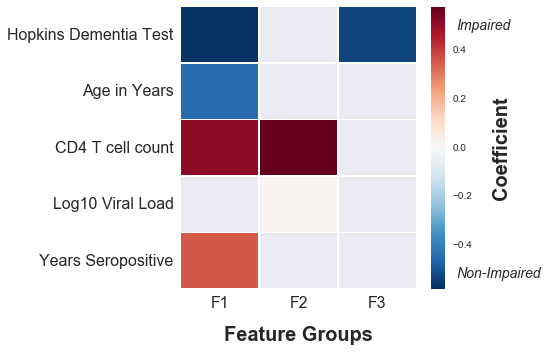

In [64]:
fig,ax = plt.subplots(figsize=(7,5))
ax = sns.heatmap(coeff_df.T, linewidths=.5)
VARS = ['Years Seropositive','Log10 Viral Load','CD4 T cell count','Age in Years','Hopkins Dementia Test']
ax.set_yticklabels(VARS,fontsize=16)
ax.set_xticklabels(['F1', 'F2', 'F3'], fontsize=16)
ax.set_xlabel('Feature Groups', labelpad=15, fontsize=20, weight='bold')
ax.yaxis.set_label_position('right')
ax.set_ylabel('Coefficient', fontsize=20, weight='bold', labelpad=75)

ax.text(3.5,0.2,'Non-Impaired',fontsize=14,fontstyle='italic')
ax.text(3.5,4.6,'Impaired',fontsize=14,fontstyle='italic')
fig.tight_layout()
plt.show()

savepath = '/Users/Greg/Projects/HIV_Neuro_NGS/Figures/clin_roc_coeff.png'
fig.savefig(savepath,dpi=300, bbox_inches='tight')

# Random Forest??

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
target = 'GDS'
threshold = 0.5
folds = 5
#features = f4

# record data for different feature sets
AUC1, AUC2 = [], []
PREC1, PREC2 = [], []
REC1, REC2 = [], []
F1, F2 = [], []
TPR1, TPR2 = [], []
FPR1, FPR2 = [], []
#COEF1, COEF2 = [], []

for features in feats:
    print features

    # ridge model
    ridge_model = RandomForestClassifier(class_weight='balanced')

    # shuffle and analyze the dataframe 100 times ####################################
    auc1, auc2 = [], []
    prec1, prec2 = [], []
    rec1, rec2 = [], []
    f1, f2 = [], []
    tpr1, tpr2 = [], []
    fpr1, fpr2 = [], []
    #coef1, coef2 = [], []

    for _ in range(100):

        # shuffle the dataframe
        df_shuffled = tnf.shuffle_dataframe(df)

        # select 100 samples from the shuffled dataframe
        # prepare the dataframe for sklearn
        X_df, y = tnf.run_preparation_pipeline2(df_shuffled[:100], features, target, threshold)

        # run k-fold cross validation
        ridge_metrics = tnf.get_RF_CV_metrics(ridge_model, X_df[features], y, folds)

        # append data for each random sample 
        # ridge metrics
        auc2.append(np.mean(ridge_metrics['AUC']))
        prec2.append(np.mean(ridge_metrics['Precision']))
        rec2.append(np.mean(ridge_metrics['Recall']))
        f2.append(np.mean(ridge_metrics['F1']))
        tpr2.append(ridge_metrics['meanTPR'])
        fpr2.append(ridge_metrics['meanFPR'])
        #coef2.append(ridge_metrics['Coef'])

    #append results for each model
    AUC2.append(auc2)
    PREC2.append(prec2)
    REC2.append(rec2)
    F2.append(f2)
    TPR2.append(tpr2) 
    FPR2.append(fpr2) 
    #COEF2.append(coef2)

['Age', 'Years_seropositive', 'TMHDS', 'CD4']
['log10_VL', 'CD4']
['TMHDS']


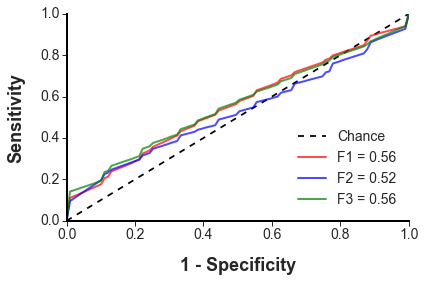

In [56]:
# iterate through the combinations of features

fig,ax=plt.subplots(figsize=(6,4))

# formatting
ax.tick_params(axis='x', labelsize=14, length=5)
ax.tick_params(axis='y', labelsize=14, length=5)
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.set_xlabel('1 - Specificity', size=18, labelpad=15, weight='bold')
ax.set_ylabel('Sensitivity', size=18, labelpad=15, weight='bold')
ax.set_axis_bgcolor('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.ticklabel_format(size=20)
ax.plot([0, 1], [0, 1], ls='--', color='black', label='Chance')
clrs = ['red','blue','green','purple','orange','deeppink','aqua','gold','lime','sienna']

for j in range(len(feats)):
    # returns a list of arrays
    f = FPR2[j]
    t = TPR2[j]
    a = str(round(np.mean(AUC2[j]),2))
    
    # initialize a mean TRP and FPR
    X = np.zeros(len(f[0]))
    Y = np.zeros(len(t[0]))
    # iterate through each randomization
    for i in range(len(t)):
        X = X + f[i]
        Y = Y + t[i]
    X = X/len(t)
    Y = Y/len(t)
    ax.plot(X, Y, color=clrs[j], ls='-', label='F'+str(j+1)+' = '+a, linewidth=2, alpha=0.7)

fig.tight_layout()
plt.legend(bbox_to_anchor=[1, 0.5],ncol=1,fontsize=14)

savepath = '/Users/Greg/Documents/Drexel/ML/finalstoryfigs/clin_rf_roc_plots.png'
fig.savefig(savepath,dpi=300, bbox_inches='tight')